In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32987")
client

<Client: 'tcp://127.0.0.1:32987' processes=3 threads=3, memory=8.79 GiB>

In [2]:
import xarray as xr
import numpy as np
import os.path as op
import xrft
from scipy.interpolate import griddata
import scipy
from xmovie import Movie
import matplotlib.pyplot as plt
%matplotlib inline

/mnt/meom/workdir/legarrem/miniconda3/envs/meomstage/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ddir = '/mnt/meom/workdir/uchidat/Stage/LeGarrec'
savedir = '/mnt/meom/workdir/legarrem/'

In [4]:
dst = xr.open_zarr(op.join(ddir,'SST_15N-50N.zarr'))
dst

<xarray.Dataset>
Dimensions:  (YC: 423, XC: 1000, nmemb: 48, time: 36, XG: 1000, YG: 423)
Coordinates: (12/29)
    Depth    (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    PHrefC   float32 ...
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * XG       (XG) float32 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * YC       (YC) float32 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
  * YG       (YG) float32 14.96 15.04 15.13 15.21 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (YC, XG) int8 dask.array<chunksize=(212, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rhoRef   float32 ...
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
Dimensions without coordinates: nmemb
Data variables:
    THETA    (nmemb, time, YC, XC) float32 dask.array<chunksize=(6, 5, 106, 250), meta=np.ndarray>

In [5]:
Tb = dst.THETA.mean('nmemb',skipna=True)   # Mean over the ensemble dimension
Tp = dst.THETA - Tb                        # Residual from the ensemble mean

In [6]:
size_X = dst.XC.size
size_Y = dst.YC.size
size_t = dst.time.size
size_n = dst.nmemb.size

## I. σ²(t)

In [7]:
Tstd = dst.THETA.std('nmemb',skipna=True) # Standard deviation over the ensemble dimension
Tvar = dst.THETA.var('nmemb',skipna=True) # Variance over the ensemble dimension
A = dst.rA.sum()

In [8]:
Integrate_Var_time = (Tvar*dst.rA).sum(['XC', 'YC'])
Var_t = Integrate_Var_time/A

#### Variance in time 

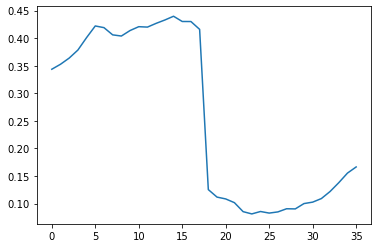

In [9]:
time = range(0, size_t)
plt.plot(time, Var_t)
plt.savefig(op.join(savedir,'imageVart.png'))

## II. Power Spectrum

### a. Regular sliced grid

In [10]:
#Slicing the map between longitude (35° to 50°) and latitude (310° to 330°)
sliced_data = dst.sel(YG=slice(35,50), XG=slice(310,330)).sel(YC=slice(35,50),XC=slice(310,330)).where(dst.maskInC!=0.)
sliced_data = sliced_data.isel(XC=slice(0,sliced_data.XG.size))

In [11]:
#non-uniform grid in km
ms_x = np.cumsum(sliced_data.dxC.values, axis = 1)/1000
ms_y = np.cumsum(sliced_data.dyC.values, axis = 0)/1000
ms_grid = np.dstack([ms_y, ms_x]).reshape(-1, 2)

In [12]:
diff_N = ms_x[-1][-1] - ms_x[-1][0] # size of the the northernmost latitude in km 
diff_S = ms_x[0][-1] - ms_x[0][0] # size of the the southernmost latitude in km 
N_S_diff = diff_S - diff_N # difference between nothernmost and southernmost latitude in km

size_toplat = int(np.ceil(diff_N)) # size of the the northernmost latitude in km
size_lon = int(np.ceil(ms_y[-1][-1])) # size of one longitude in km

first_sx =  int(np.floor(ms_x[0][0] + N_S_diff/2)) # New first point (cast in integer) on latitude 
first_sy = int(np.floor(ms_y[0][0])) # First point (cast in integer) on longitude 

In [13]:
#uniform grid in km (by 10 km step)
step = 10
grid_x, grid_y = np.mgrid[first_sy:size_lon:step, first_sx:size_toplat:step]

In [14]:
x_values = grid_y[0] #Values in km on X-axis from uniform grid
y_values = (grid_x.T)[0] #Values in km on Y-axis from uniform grid

#### Example of the sliced map (first simulation, first time step)

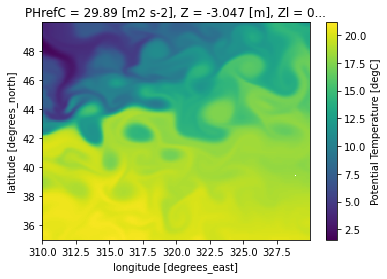

In [15]:
sliced_data.THETA.isel(nmemb=0,time=0).plot(rasterized=True, cmap="viridis")

### b. Interpolate the regular grid

In [16]:
n_data = xr.DataArray(np.zeros((size_n, size_t, y_values.size, x_values.size)), dims=["nmemb", "time", "Ym", "Xm"], 
                      coords=dict(nmemb=(["nmemb"], dst.nmemb.values), 
                                  time=(["time"], dst.time.values), 
                                  Ym=(["Ym"], y_values), 
                                  Xm=(["Xm"], x_values)))
n_data.chunk({'nmemb':6,'time':6})

<xarray.DataArray (nmemb: 48, time: 36, Ym: 166, Xm: 123)>
dask.array<xarray-<this-array>, shape=(48, 36, 166, 123), dtype=float64, chunksize=(6, 6, 166, 123), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
  * Ym       (Ym) int64 9 19 29 39 49 59 69 ... 1609 1619 1629 1639 1649 1659
  * Xm       (Xm) int64 201 211 221 231 241 251 ... 1381 1391 1401 1411 1421

In [17]:
for j in range(0, int(size_n)):
    for i in range(0,int(size_t)):
            ji_values = sliced_data.THETA.isel(nmemb=j,time=i).values.flatten()
            n_data[j][i] = griddata(ms_grid, ji_values, (grid_x, grid_y), method='nearest')

In [18]:
n_data.to_dataset(name='THETA').to_zarr(op.join(savedir,'ip_sliced_data.zarr'), mode="w")

#### Example of sliced map interpolated (first simulation, first time step)

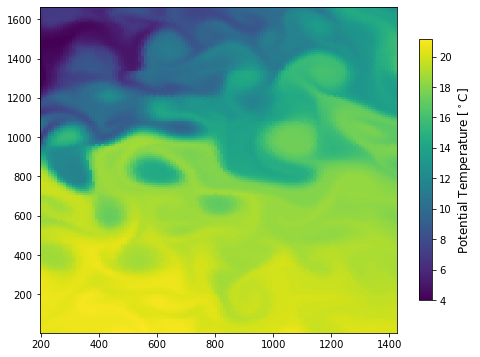

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(x_values, y_values, n_data[0][0], cmap='viridis', vmin=4)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"Potential Temperature [$^\circ$C]", fontsize=12)

### c. 2D Power spectra 

In [20]:
smap = xr.open_zarr(op.join(savedir,'ip_sliced_data.zarr'))

In [23]:
window1dX = scipy.signal.windows.hann(smap.Xm.values.size, False)
window1dY = scipy.signal.windows.hann(smap.Ym.values.size, False)
window2d = np.sqrt(np.outer(window1dY,window1dX))

In [24]:
Wsmap = xr.DataArray((window2d*smap).to_array('THETA')[0], dims=["nmemb", "time", "Ym", "Xm"], 
                      coords=dict(nmemb=(["nmemb"], smap.nmemb.values), 
                                  time=(["time"], smap.time.values), 
                                  Ym=(["Ym"], smap.Ym.values), 
                                  Xm=(["Xm"], smap.Xm.values)))
Wsmap = Wsmap.chunk((6, 6, smap.Ym.size, smap.Xm.values.size))

In [26]:
WPSpectra = xrft.power_spectrum(Wsmap, dim=['Ym', 'Xm'])

#### Example of windowed signal and power spectrum

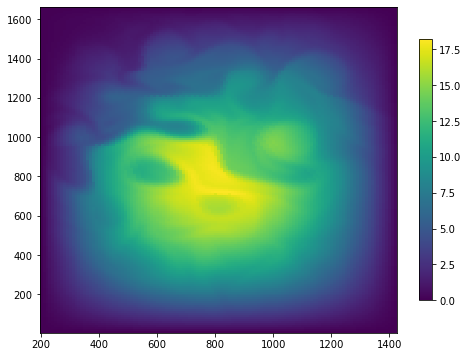

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(smap.Xm.values, smap.Ym.values, Wsmap[0][0], cmap='viridis')
cbar = fig.colorbar(im, ax=ax, shrink=.8)

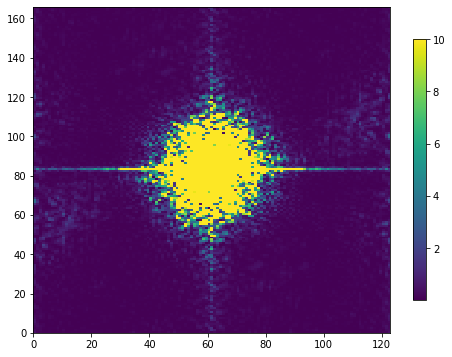

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(WPSpectra[0][0], cmap='viridis', vmax=10e0, vmin=10e-6)
cbar = fig.colorbar(im, ax=ax, shrink=.8)

### Isotropic Power Spectrum

In [29]:
isoPS = xrft.isotropic_power_spectrum(smap.to_array('THETA')[0].chunk((6, 6, smap.Ym.size, smap.Xm.values.size)), 
                                      dim=['Ym', 'Xm'], window="hann", window_correction=True, truncate=True)

In [30]:
isoPSwinter = isoPS.isel(time=slice(0,int((size_t/2)-1)))
isoPSsummer = isoPS.isel(time=slice(int(size_t/2), size_t))

#### Isotropic power spectrum of winter and summer (averaged on time and ensemble dimension)

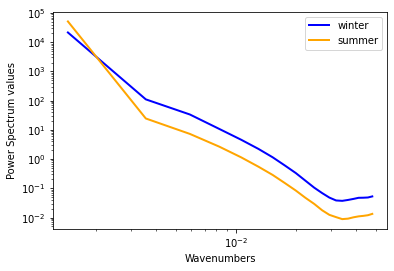

In [31]:
fig, ax = plt.subplots()
winter_line = ax.plot(isoPS.freq_r, isoPSwinter.mean(['nmemb','time']), lw=2, color="blue", label="winter")
summer_line = ax.plot(isoPS.freq_r, isoPSsummer.mean(['nmemb','time']), lw=2, color="orange", label="summer")

plt.ylabel('Power Spectrum values')
plt.xlabel('Wavenumbers')
ax.set_xscale('log')
ax.set_yscale('log')

legend = ax.legend(loc='upper right')
plt.show()